# Επεξεργασία μονόχρωμης (binary) εικόνας

Παράδειγμα χρήσης βασικών τεχνικών επεξεργασίας μονόχρωμων εικόνων για την επίλυση πραγματικών προβλημάτων της περιοχής της μηχανικής όρασης.

## Εφαρμογή στην καταμέτρηση αντικειμένων σε μια εικόνα

In [1]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow #this is used for imshow to work on google colab
from google.colab import drive
import sys
import os

In [2]:
drive.mount('/content/gdrive')
lib_file_location = "/content/gdrive/My Drive/DIP"
sys.path.append(lib_file_location)

Mounted at /content/gdrive


In [4]:
# Read / Show an image
img_file = '/content/gdrive/MyDrive/DIP/coins.jpg'
image = cv2.imread(img_file) # this image is in BGR format

In [5]:
image_blur = cv2.medianBlur(image,25) # προεπεξεργασία με ένα μικρό low-pass φίλτρο
image_blur_gray = cv2.cvtColor(image_blur, cv2.COLOR_BGR2GRAY) # μετατροπή σε gray-scale
image_res ,image_thresh = cv2.threshold(image_blur_gray,240,255,cv2.THRESH_BINARY_INV) #εφαρμογή κατωφλίωσης για μετατροπή σε μονόχρωμη


In [10]:
kernel = np.ones((3,3),np.uint8)

# OPENING Morphological operation
opening = cv2.morphologyEx(image_thresh,cv2.MORPH_OPEN,kernel)

# υπολογισμός αποστάσεων κάθε pixel αντικειμένου από το background
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

# επιλογή συγκεκριμένων pixel με αποστάσεις Κ*max_distance (K-> παράμετρος που επιλέγεται)
ret, last_image =  cv2.threshold(dist_transform, 0.1*dist_transform.max(),255,0)

# η τελική εικόνα που προκύπτει
last_image = np.uint8(last_image)

# Εύρεση περιγραμμάτων στην εικόνα
cnts,_ = cv2.findContours(last_image.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

contours_poly = [None]*len(cnts)
boundRect = [None]*len(cnts)
centers = [None]*len(cnts)
radius = [None]*len(cnts)

In [11]:
# Μια συνάρτηση για την ευκολότερη απεικόνιση των αντικειμένων

import random as rng

def display(img,count,cmap="gray"):
    f_image = cv2.imread(img_file) # this image is in BGR format
    f, axs = plt.subplots(1,2,figsize=(12,5))
    axs[0].imshow(f_image,cmap="gray")
    axs[1].imshow(img,cmap="gray")
    axs[1].set_title("Συνολικός Αριθμός αντικειμένων = {}".format(count))

In [12]:
for (i, c) in enumerate(cnts):
    # Approximate contours to polygons + get bounding rects and circles
    contours_poly[i] = cv2.approxPolyDP(c, 3, True)

    # δημιουργία bounding box γύρω από την πολυγωνική περιοχή που υπολογίστηκε
    boundRect[i] = cv2.boundingRect(contours_poly[i])

    # δημιουργία bounding κύκλου γύρω από την πολυγωνική περιοχή που υπολογίστηκε
    centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])

drawing = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

# Draw polygonal contour + bonding rects + circles
for i in range(len(cnts)):
  color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))

  #σχεδιασμός των contours
  cv2.drawContours(drawing, contours_poly, i, color)
  cv2.drawContours(image, contours_poly, i, color)

  #σχεδιασμός bounding boxes
  cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])),(int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
  cv2.rectangle(image, (int(boundRect[i][0]), int(boundRect[i][1])),(int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)

  #σχεδιασμός των bounding circles
  cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
  cv2.circle(image, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)


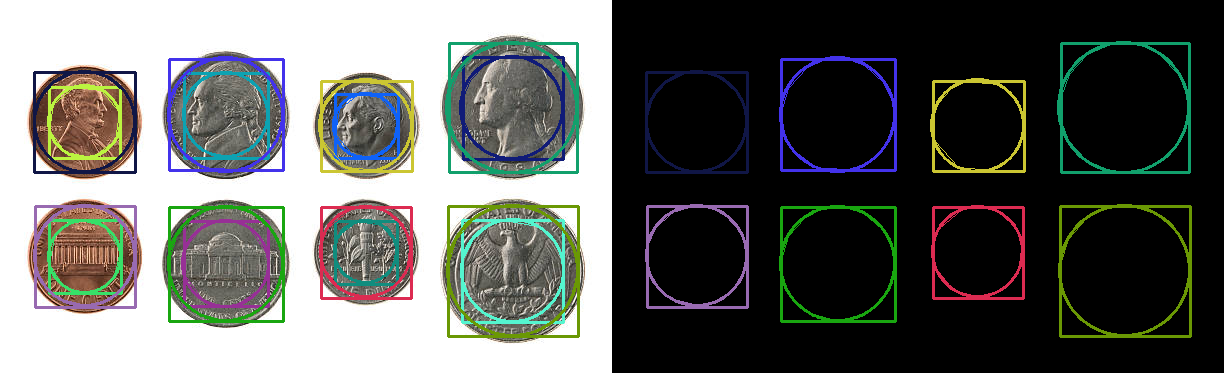

In [14]:
# Εμφάνιση αρχικής εικόνας και αποτελεσμάτων

res = np.hstack((image, drawing))
cv2_imshow(res)
